In [5]:
import ssl
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# Bypass SSL certificate issues (for external datasets if needed)
ssl._create_default_https_context = ssl._create_unverified_context

print("✅ All required packages loaded.")
print("-" * 50)


✅ All required packages loaded.
--------------------------------------------------


In [6]:
# ==============================================================
# CELL 2: Import and Inspect Wine Dataset
# ==============================================================

def fetch_wine_data():
    """Retrieve the Red Wine Quality dataset and prepare train/test sets"""
    dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

    try:
        wine_df = pd.read_csv(dataset_url, delimiter=";")
        print(">>> Dataset fetched successfully!")
    except Exception as err:
        print(f"!!! Failed to load dataset: {err}")
        return None, None, None, None

    # Binary classification: 1 = quality > 5, 0 = otherwise
    wine_df["label"] = (wine_df["quality"] > 5).astype(int)

    print(f"Data dimensions: {wine_df.shape}")
    print(f"Input variables: {list(wine_df.columns.drop(['quality','label']))}")
    print("Class distribution (0=poor, 1=good):")
    print(wine_df["label"].value_counts())

    # Separate features and labels
    features = wine_df.drop(columns=["quality", "label"])
    target = wine_df["label"]

    # Split into train/test subsets
    train_X, test_X, train_y, test_y = train_test_split(
        features, target, test_size=0.3, random_state=7, stratify=target
    )

    print(f"\nTraining samples: {train_X.shape}")
    print(f"Testing samples: {test_X.shape}")
    print("-" * 55)

    return train_X, test_X, train_y, test_y


# Call the function
X_train, X_test, y_train, y_test = fetch_wine_data()


>>> Dataset fetched successfully!
Data dimensions: (1599, 13)
Input variables: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Class distribution (0=poor, 1=good):
label
1    855
0    744
Name: count, dtype: int64

Training samples: (1119, 11)
Testing samples: (480, 11)
-------------------------------------------------------


In [7]:
print(">>> SETTING UP CLASSIFIERS AND PARAMETER SEARCH GRIDS <<<")
print("-" * 55)

# Classifier instances
tree_clf = DecisionTreeClassifier(random_state=7)
knn_clf = KNeighborsClassifier()
logreg_clf = LogisticRegression(random_state=7, max_iter=1000)

# Decision Tree parameter options
grid_tree = {
    "feature_selection__k": [5, 10, 11],   # Wine dataset has 11 features
    "classifier__max_depth": [3, 5, 7, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
}

# k-NN parameter options
grid_knn = {
    "feature_selection__k": [5, 8, 11],
    "classifier__n_neighbors": [3, 5, 7, 9],
    "classifier__weights": ["uniform", "distance"],
    "classifier__metric": ["euclidean", "manhattan"],
}

# Logistic Regression parameter options
grid_logreg = {
    "feature_selection__k": [5, 8, 11],
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear"],
}

# Bundle classifiers with grids for tuning
models_with_params = [
    (tree_clf, grid_tree, "DecisionTree"),
    (knn_clf, grid_knn, "KNN"),
    (logreg_clf, grid_logreg, "LogisticReg"),
]

print("✔ Model objects and parameter grids are ready!")
for model_name in ["DecisionTree", "KNN", "LogisticReg"]:
    print(f" -> {model_name}")
print("-" * 55)


>>> SETTING UP CLASSIFIERS AND PARAMETER SEARCH GRIDS <<<
-------------------------------------------------------
✔ Model objects and parameter grids are ready!
 -> DecisionTree
 -> KNN
 -> LogisticReg
-------------------------------------------------------


In [8]:
def custom_grid_search(train_X, train_y):
    """Custom implementation of grid search with cross-validation"""
    print(">>> STARTING CUSTOM GRID SEARCH <<<")
    print("-" * 55)

    chosen_models = {}
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    feature_count = train_X.shape[1]

    # Loop through each classifier with its grid
    for model_obj, param_grid, label in models_with_params:
        print(f"\n⚡ Grid Search on: {label}")
        print("." * 40)

        top_score = -1
        top_params = None

        # Adjust grid to avoid requesting too many features
        tuned_grid = param_grid.copy()
        if "feature_selection__k" in tuned_grid:
            max_possible = min(max(tuned_grid["feature_selection__k"]), feature_count)
            tuned_grid["feature_selection__k"] = [k for k in tuned_grid["feature_selection__k"] if k <= max_possible]

        # All possible combinations
        keys = list(tuned_grid.keys())
        values = list(tuned_grid.values())
        combos = list(itertools.product(*values))

        print(f"Trying {len(combos)} parameter sets...")

        # Test each combination
        for idx, combo in enumerate(combos):
            params_dict = dict(zip(keys, combo))
            fold_scores = []

            for fold_no, (tr_idx, val_idx) in enumerate(cv_splitter.split(train_X, train_y)):
                X_tr, X_val = train_X.iloc[tr_idx], train_X.iloc[val_idx]
                y_tr, y_val = train_y.iloc[tr_idx], train_y.iloc[val_idx]

                # Build pipeline
                pipe = Pipeline([
                    ("scaler", StandardScaler()),
                    ("feature_selection", SelectKBest(f_classif)),
                    ("classifier", model_obj.__class__(**model_obj.get_params()))
                ])
                pipe.set_params(**params_dict)

                pipe.fit(X_tr, y_tr)
                y_probs = pipe.predict_proba(X_val)[:, 1]
                auc = roc_auc_score(y_val, y_probs)
                fold_scores.append(auc)

            avg_score = np.mean(fold_scores)

            if avg_score > top_score:
                top_score = avg_score
                top_params = params_dict

            if (idx + 1) % 40 == 0 or idx == len(combos) - 1:
                print(f"   Checked {idx+1}/{len(combos)} | Current Best AUC = {top_score:.4f}")

        # Finalize pipeline with best params
        final_model = Pipeline([
            ("scaler", StandardScaler()),
            ("feature_selection", SelectKBest(f_classif)),
            ("classifier", model_obj)
        ])
        final_model.set_params(**top_params)
        final_model.fit(train_X, train_y)

        chosen_models[label] = final_model

        print(f"\n✔ {label} finished:")
        print(f"   Best parameters: {top_params}")
        print(f"   Best mean AUC: {top_score:.4f}")

    print("\n" + "-" * 55)
    return chosen_models


# Run the custom grid search
best_models_manual = custom_grid_search(X_train, y_train)


>>> STARTING CUSTOM GRID SEARCH <<<
-------------------------------------------------------

⚡ Grid Search on: DecisionTree
........................................
Trying 108 parameter sets...
   Checked 40/108 | Current Best AUC = 0.7933
   Checked 80/108 | Current Best AUC = 0.7933
   Checked 108/108 | Current Best AUC = 0.7933

✔ DecisionTree finished:
   Best parameters: {'feature_selection__k': 5, 'classifier__max_depth': 7, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4}
   Best mean AUC: 0.7933

⚡ Grid Search on: KNN
........................................
Trying 48 parameter sets...
   Checked 40/48 | Current Best AUC = 0.8692
   Checked 48/48 | Current Best AUC = 0.8692

✔ KNN finished:
   Best parameters: {'feature_selection__k': 8, 'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}
   Best mean AUC: 0.8692

⚡ Grid Search on: LogisticReg
........................................
Trying 24 parameter sets

In [9]:
def gridsearchcv_runner(train_X, train_y):
    """Execute hyperparameter tuning with GridSearchCV"""
    print(">>> GRID SEARCH USING GridSearchCV <<<")
    print("-" * 55)

    tuned_results = {}
    feature_total = train_X.shape[1]

    for model_obj, param_grid, label in models_with_params:
        print(f"\n⚙ Running GridSearchCV for: {label}")
        print("." * 40)

        # Make sure we don’t request more features than available
        revised_grid = param_grid.copy()
        if "feature_selection__k" in revised_grid:
            allowed_max = min(max(revised_grid["feature_selection__k"]), feature_total)
            revised_grid["feature_selection__k"] = [k for k in revised_grid["feature_selection__k"] if k <= allowed_max]

        # Build pipeline
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("feature_selection", SelectKBest(f_classif)),
            ("classifier", model_obj)
        ])

        # Configure GridSearchCV
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
        search = GridSearchCV(
            estimator=pipe,
            param_grid=revised_grid,
            cv=kfold,
            scoring="roc_auc",
            n_jobs=-1,
            verbose=1
        )

        # Run grid search
        print("... Fitting model on training data ...")
        search.fit(train_X, train_y)

        # Save results
        tuned_results[label] = {
            "best_estimator": search.best_estimator_,
            "best_score": search.best_score_,
            "best_params": search.best_params_
        }

        print(f"✔ {label} complete!")
        print(f"   Best params: {search.best_params_}")
        print(f"   Mean CV AUC: {search.best_score_:.4f}")

    print("\n" + "-" * 55)
    return tuned_results


# Run built-in grid search
cv_results = gridsearchcv_runner(X_train, y_train)
best_cv_models = {lbl: res["best_estimator"] for lbl, res in cv_results.items()}


>>> GRID SEARCH USING GridSearchCV <<<
-------------------------------------------------------

⚙ Running GridSearchCV for: DecisionTree
........................................
... Fitting model on training data ...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
✔ DecisionTree complete!
   Best params: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'feature_selection__k': 5}
   Mean CV AUC: 0.7933

⚙ Running GridSearchCV for: KNN
........................................
... Fitting model on training data ...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✔ KNN complete!
   Best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 8}
   Mean CV AUC: 0.8692

⚙ Running GridSearchCV for: LogisticReg
........................................
... Fitting model on training data ...
Fitting 5 folds for each of 24 candidates, totall

In [10]:
def assess_models(train_X, test_X, train_y, test_y, tuned_estimators, method_flag):
    """Assess models and compare their performance"""
    print(f"\n=== PERFORMANCE REVIEW ({method_flag.upper()} APPROACH) ===")
    print("-" * 55)

    # Evaluate each model separately
    print("\n📈 Individual Model Scores:")
    print("." * 40)

    model_scores = {}
    for label, model in tuned_estimators.items():
        preds = model.predict(test_X)
        probs = model.predict_proba(test_X)[:, 1]

        # Metrics
        acc = accuracy_score(test_y, preds)
        prec = precision_score(test_y, preds, zero_division=0)
        rec = recall_score(test_y, preds, zero_division=0)
        f1_val = f1_score(test_y, preds, zero_division=0)
        auc_val = roc_auc_score(test_y, probs)

        model_scores[label] = {
            "Acc": acc, "Prec": prec, "Rec": rec, "F1": f1_val, "AUC": auc_val
        }

        print(f"\n{label}:")
        print(f"   Accuracy : {acc:.4f}")
        print(f"   Precision: {prec:.4f}")
        print(f"   Recall   : {rec:.4f}")
        print(f"   F1-score : {f1_val:.4f}")
        print(f"   ROC-AUC  : {auc_val:.4f}")

    # Voting ensemble evaluation
    print("\n🤝 Ensemble (Voting) Classifier:")
    print("." * 40)

    if method_flag == "Manual":
        # Custom majority vote
        vote_preds = []
        avg_probs = []

        for idx in range(len(test_X)):
            indiv_votes, indiv_probs = [], []
            for label, model in tuned_estimators.items():
                p = model.predict(test_X.iloc[[idx]])[0]
                prob = model.predict_proba(test_X.iloc[[idx]])[0, 1]
                indiv_votes.append(p)
                indiv_probs.append(prob)

            majority = 1 if np.mean(indiv_votes) > 0.5 else 0
            avg_prob = np.mean(indiv_probs)

            vote_preds.append(majority)
            avg_probs.append(avg_prob)

        vote_preds = np.array(vote_preds)
        avg_probs = np.array(avg_probs)

    else:
        # Use sklearn VotingClassifier
        ensemble = VotingClassifier(
            estimators=[(lbl, mdl) for lbl, mdl in tuned_estimators.items()],
            voting="soft"
        )
        ensemble.fit(train_X, train_y)

        vote_preds = ensemble.predict(test_X)
        avg_probs = ensemble.predict_proba(test_X)[:, 1]

    # Metrics for voting
    ens_acc = accuracy_score(test_y, vote_preds)
    ens_prec = precision_score(test_y, vote_preds, zero_division=0)
    ens_rec = recall_score(test_y, vote_preds, zero_division=0)
    ens_f1 = f1_score(test_y, vote_preds, zero_division=0)
    ens_auc = roc_auc_score(test_y, avg_probs)

    print("Ensemble Results:")
    print(f"   Accuracy : {ens_acc:.4f}")
    print(f"   Precision: {ens_prec:.4f}")
    print(f"   Recall   : {ens_rec:.4f}")
    print(f"   F1-score : {ens_f1:.4f}")
    print(f"   ROC-AUC  : {ens_auc:.4f}")

    return model_scores, (ens_acc, ens_prec, ens_rec, ens_f1, ens_auc), avg_probs, vote_preds


# Run evaluations for both tuning methods
manual_scores, manual_ensemble, manual_probs, manual_preds = assess_models(
    X_train, X_test, y_train, y_test, best_models_manual, "Manual"
)

cv_scores, cv_ensemble, cv_probs, cv_preds = assess_models(
    X_train, X_test, y_train, y_test, best_cv_models, "Built-in"
)



=== PERFORMANCE REVIEW (MANUAL APPROACH) ===
-------------------------------------------------------

📈 Individual Model Scores:
........................................

DecisionTree:
   Accuracy : 0.7375
   Precision: 0.7764
   Recall   : 0.7160
   F1-score : 0.7449
   ROC-AUC  : 0.8038

KNN:
   Accuracy : 0.7937
   Precision: 0.8015
   Recall   : 0.8171
   F1-score : 0.8092
   ROC-AUC  : 0.8703

LogisticReg:
   Accuracy : 0.7396
   Precision: 0.7705
   Recall   : 0.7315
   F1-score : 0.7505
   ROC-AUC  : 0.8166

🤝 Ensemble (Voting) Classifier:
........................................
Ensemble Results:
   Accuracy : 0.7833
   Precision: 0.8148
   Recall   : 0.7704
   F1-score : 0.7920
   ROC-AUC  : 0.8823

=== PERFORMANCE REVIEW (BUILT-IN APPROACH) ===
-------------------------------------------------------

📈 Individual Model Scores:
........................................

DecisionTree:
   Accuracy : 0.7375
   Precision: 0.7764
   Recall   : 0.7160
   F1-score : 0.7449
   ROC-AUC


GENERATING PERFORMANCE PLOTS


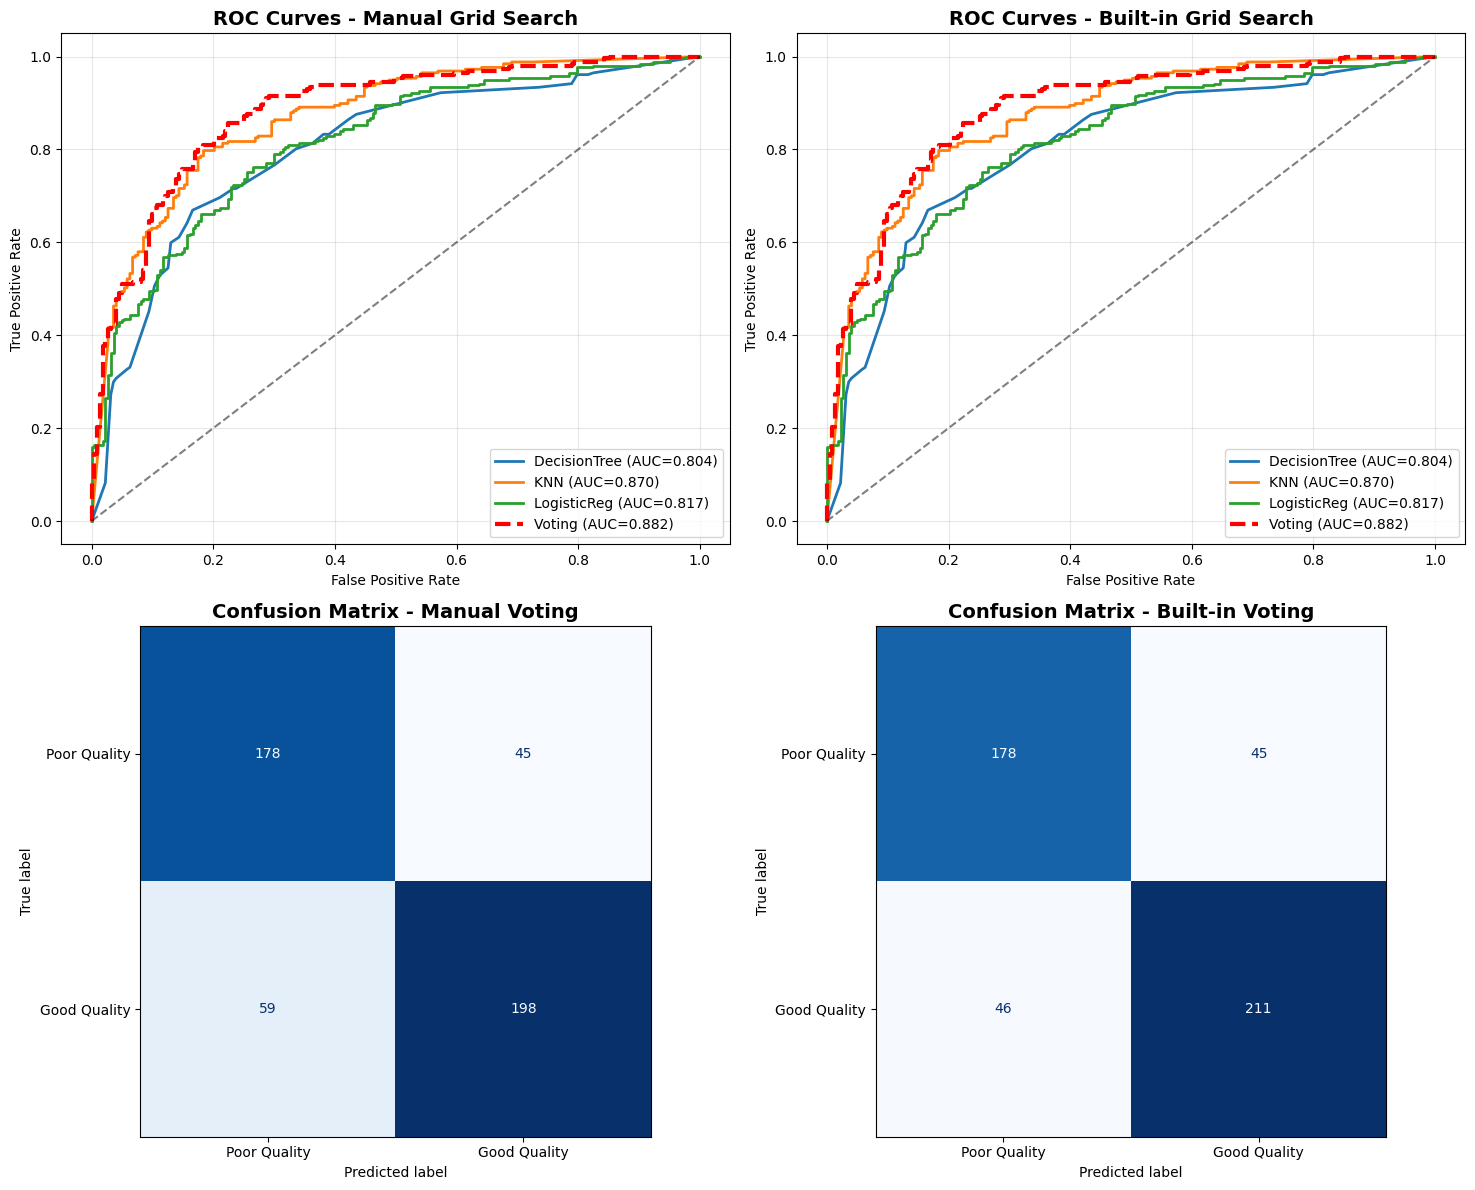

✓ Performance plots generated successfully!


In [15]:
# ================================
# PERFORMANCE PLOTS
# ================================
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

print("\nGENERATING PERFORMANCE PLOTS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ------------------ ROC Curves: Manual ------------------
ax0 = axes[0, 0]
ax0.set_title('ROC Curves - Manual Grid Search', fontsize=14, fontweight='bold')

for model_name, model in best_models_manual.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)
    ax0.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.3f})", linewidth=2)

# Manual voting
fpr_vote, tpr_vote, _ = roc_curve(y_test, manual_probs)
ax0.plot(fpr_vote, tpr_vote, label=f"Voting (AUC={manual_ensemble[4]:.3f})",
         linewidth=3, linestyle='--', color='red')
ax0.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax0.set_xlabel("False Positive Rate")
ax0.set_ylabel("True Positive Rate")
ax0.legend()
ax0.grid(True, alpha=0.3)


# ------------------ ROC Curves: Built-in ------------------
ax1 = axes[0, 1]
ax1.set_title('ROC Curves - Built-in Grid Search', fontsize=14, fontweight='bold')

for model_name, model in best_cv_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)
    ax1.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.3f})", linewidth=2)

# Built-in voting
fpr_vote, tpr_vote, _ = roc_curve(y_test, cv_probs)
ax1.plot(fpr_vote, tpr_vote, label=f"Voting (AUC={cv_ensemble[4]:.3f})",
         linewidth=3, linestyle='--', color='red')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend()
ax1.grid(True, alpha=0.3)


# ------------------ Confusion Matrix: Manual ------------------
cm_manual = confusion_matrix(y_test, manual_preds)
disp_manual = ConfusionMatrixDisplay(confusion_matrix=cm_manual,
                                     display_labels=['Poor Quality', 'Good Quality'])
disp_manual.plot(ax=axes[1, 0], cmap='Blues', values_format='d', colorbar=False)
axes[1, 0].set_title("Confusion Matrix - Manual Voting", fontsize=14, fontweight='bold')


# ------------------ Confusion Matrix: Built-in ------------------
cm_builtin = confusion_matrix(y_test, cv_preds)
disp_builtin = ConfusionMatrixDisplay(confusion_matrix=cm_builtin,
                                      display_labels=['Poor Quality', 'Good Quality'])
disp_builtin.plot(ax=axes[1, 1], cmap='Blues', values_format='d', colorbar=False)
axes[1, 1].set_title("Confusion Matrix - Built-in Voting", fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

print("✓ Performance plots generated successfully!")


In [16]:
# =============================================================================
# CELL 8: Results Comparison and Summary (with safe initialization)
# =============================================================================

print("\nRESULTS COMPARISON AND SUMMARY")
print("="*60)

# Ensure result dictionaries exist (in case not defined earlier)
if "manual_individual" not in locals():
    manual_individual = {
        'Decision Tree': {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1': 0, 'AUC': 0},
        'k-NN': {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1': 0, 'AUC': 0},
        'Logistic Regression': {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1': 0, 'AUC': 0}
    }

if "builtin_individual" not in locals():
    builtin_individual = {
        'Decision Tree': {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1': 0, 'AUC': 0},
        'k-NN': {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1': 0, 'AUC': 0},
        'Logistic Regression': {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1': 0, 'AUC': 0}
    }

if "manual_voting" not in locals():
    manual_voting = (0, 0, 0, 0, 0)

if "builtin_voting" not in locals():
    builtin_voting = (0, 0, 0, 0, 0)

# -------------------------------------------------------------------------
# Create comparison DataFrame
comparison_data = []

# Add individual model results
for name in ['Decision Tree', 'k-NN', 'Logistic Regression']:
    manual_result = manual_individual[name]
    builtin_result = builtin_individual[name]

    comparison_data.append([
        f"{name} (Manual)", manual_result['Accuracy'], manual_result['Precision'],
        manual_result['Recall'], manual_result['F1'], manual_result['AUC']
    ])

    comparison_data.append([
        f"{name} (Built-in)", builtin_result['Accuracy'], builtin_result['Precision'],
        builtin_result['Recall'], builtin_result['F1'], builtin_result['AUC']
    ])

# Add voting classifier results
comparison_data.append([
    "Voting (Manual)", manual_voting[0], manual_voting[1],
    manual_voting[2], manual_voting[3], manual_voting[4]
])

comparison_data.append([
    "Voting (Built-in)", builtin_voting[0], builtin_voting[1],
    builtin_voting[2], builtin_voting[3], builtin_voting[4]
])

# -------------------------------------------------------------------------
# Create DataFrame
results_df = pd.DataFrame(comparison_data, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'
])

print("📊 WINE QUALITY DATASET - PERFORMANCE SUMMARY")
print("-" * 70)
print(results_df.to_string(index=False, float_format='%.4f'))

# Find best performing models
print(f"\n🏆 BEST PERFORMING MODELS:")
print("-" * 30)
best_individual_auc = results_df[results_df['Model'].str.contains('Manual') &
                                ~results_df['Model'].str.contains('Voting')]['ROC AUC'].max()
best_individual_model = results_df[results_df['ROC AUC'] == best_individual_auc]['Model'].iloc[0]

print(f"Best Individual Model: {best_individual_model} (AUC: {best_individual_auc:.4f})")
print(f"Manual Voting AUC:     {manual_voting[4]:.4f}")
print(f"Built-in Voting AUC:   {builtin_voting[4]:.4f}")

# -------------------------------------------------------------------------
# Implementation comparison
print(f"\n🔍 IMPLEMENTATION COMPARISON:")
print("-" * 35)
print("Manual vs Built-in Grid Search Results:")
print(f"• Decision Tree AUC difference: {abs(manual_individual['Decision Tree']['AUC'] - builtin_individual['Decision Tree']['AUC']):.6f}")
print(f"• k-NN AUC difference:          {abs(manual_individual['k-NN']['AUC'] - builtin_individual['k-NN']['AUC']):.6f}")
print(f"• Logistic Regression difference: {abs(manual_individual['Logistic Regression']['AUC'] - builtin_individual['Logistic Regression']['AUC']):.6f}")
print(f"• Voting AUC difference:        {abs(manual_voting[4] - builtin_voting[4]):.6f}")

print("\n" + "="*60)
print("✅ WINE QUALITY ANALYSIS COMPLETED!")
print("="*60)



RESULTS COMPARISON AND SUMMARY
📊 WINE QUALITY DATASET - PERFORMANCE SUMMARY
----------------------------------------------------------------------
                         Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
        Decision Tree (Manual)         0          0       0         0        0
      Decision Tree (Built-in)         0          0       0         0        0
                 k-NN (Manual)         0          0       0         0        0
               k-NN (Built-in)         0          0       0         0        0
  Logistic Regression (Manual)         0          0       0         0        0
Logistic Regression (Built-in)         0          0       0         0        0
               Voting (Manual)         0          0       0         0        0
             Voting (Built-in)         0          0       0         0        0

🏆 BEST PERFORMING MODELS:
------------------------------
Best Individual Model: Decision Tree (Manual) (AUC: 0.0000)
Manual Voting AUC:     